In [1]:
import pandas as pd


In [2]:
import mysql.connector
from mysql.connector import Error

import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="waleedahmed",
  database="us_boxing"
)

In [3]:
import pandas as pd
cur = mydb.cursor()
sales_query = "SELECT oi.item_updated_at,oi.item_sku,p.parent_sku_id,oi.order_id AS `Order Item Order Id`,oi.sub_total,oi.item_status,o.channel_id,o.customer_type,c.name FROM order_items oi INNER JOIN orders o ON oi.order_id=o.id INNER JOIN channels c ON c.id = o.channel_id INNER JOIN products p ON oi.item_sku=p.sku"
cur.execute(sales_query)
df_sales= pd.DataFrame(data=cur.fetchall(),columns=['updated_at','sku','parent_sku','order_id','sub_total','item_status','channel_id','customer_type','channel_name'])
df_sales.head()

,updated_at,sku,parent_sku,order_id,sub_total,item_status,channel_id,customer_type,channel_name
0,2019-10-09 09:18:40,ADIH200BLKGLD14oz,5057.0,1,49.00,canceled,16,B2C,usboxing.net
1,2019-12-23 07:37:08,ADIBP10NTransparentSenior,5180.0,2,3.00,canceled,16,B2C,usboxing.net
2,2019-10-04 23:14:55,ADISBG501Black/Gold16OZ,5054.0,3,149.95,shipped,16,B2C,usboxing.net
3,2019-10-04 05:15:23,AIBAH1RedM,5130.0,4,119.95,shipped,16,B2C,usboxing.net
4,2019-09-30 22:05:26,ADIH500PROBlack/Gold/Silver14OZ,6491.0,5,169.95,shipped,16,B2C,usboxing.net


In [4]:
curr = mydb.cursor()
parents = "SELECT p.sku,p.id FROM products p WHERE p.parent_sku_id IS NULL"
curr.execute(parents)
df_parents= pd.DataFrame(data=curr.fetchall(),columns=['parent_name','parent_id'])
df_parents.head()

,parent_name,parent_id
0,ADHBG100,4517
1,ADHTG300,4526
2,ADIBCM06,4546
3,ADIH200PL,4550
4,ADIH75,4563


In [5]:
df_sales=pd.merge(df_sales,df_parents,left_on='parent_sku',right_on='parent_id',how='inner')

In [6]:
df_sales.drop(df_sales[df_sales['item_status']=='canceled'].index, inplace = True)

In [7]:
df_sales['year']=df_sales['updated_at'].dt.year
df_sales['month']=df_sales['updated_at'].dt.month


In [8]:
import seaborn as sns
twenty_twenty = df_sales.query('year== 2020')
twenty_nineteen=df_sales.query('year==2019')

In [9]:
conditions = [
    (twenty_twenty['month']>=1) & (twenty_twenty['month'] <= 3),
    (twenty_twenty['month'] >=4) & (twenty_twenty['month'] <= 6),
    (twenty_twenty['month'] >=7) & (twenty_twenty['month'] <= 9),
    (twenty_twenty['month']>=10) & (twenty_twenty['month'] <= 12)]
values = ['quarter_1', 'quarter_2', 'quarter_3', 'quarter_4']
import numpy as np
twenty_twenty['quarter'] = np.select(conditions, values)

<ipython-input-9-3107f39fd8d6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twenty_twenty['quarter'] = np.select(conditions, values)


In [10]:
conditions_2020_halfyearly = [
    (twenty_twenty['month']>=1) & (twenty_twenty['month'] <= 6),
    (twenty_twenty['month'] >=7) & (twenty_twenty['month'] <= 12)]
values_2020_half_yearly = ['1st_half', '2nd_half']
twenty_twenty['half_yearly'] = np.select(conditions_2020_halfyearly, values_2020_half_yearly)

<ipython-input-10-7ebdbd96cd4a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twenty_twenty['half_yearly'] = np.select(conditions_2020_halfyearly, values_2020_half_yearly)


In [11]:
six_months_2020=twenty_twenty.groupby(['parent_name','half_yearly','channel_name'])['order_id'].count()
six_months_2020=pd.DataFrame(six_months_2020)
six_months_2020.reset_index(inplace=True)
six_months_2020.columns=['parent_name','half_yearly','channel_name','order_count']

In [12]:
six_months_2020.head()

,parent_name,half_yearly,channel_name,order_count
0,ADIACC043CS,1st_half,usboxing.net,1
1,ADIACC043CS,2nd_half,usboxingamazon,1
2,ADIACC044CS,1st_half,usboxingamazon,2
3,ADIACC044CS,2nd_half,ebayusboxing,1
4,ADIACC044CS,2nd_half,usboxing.net,1


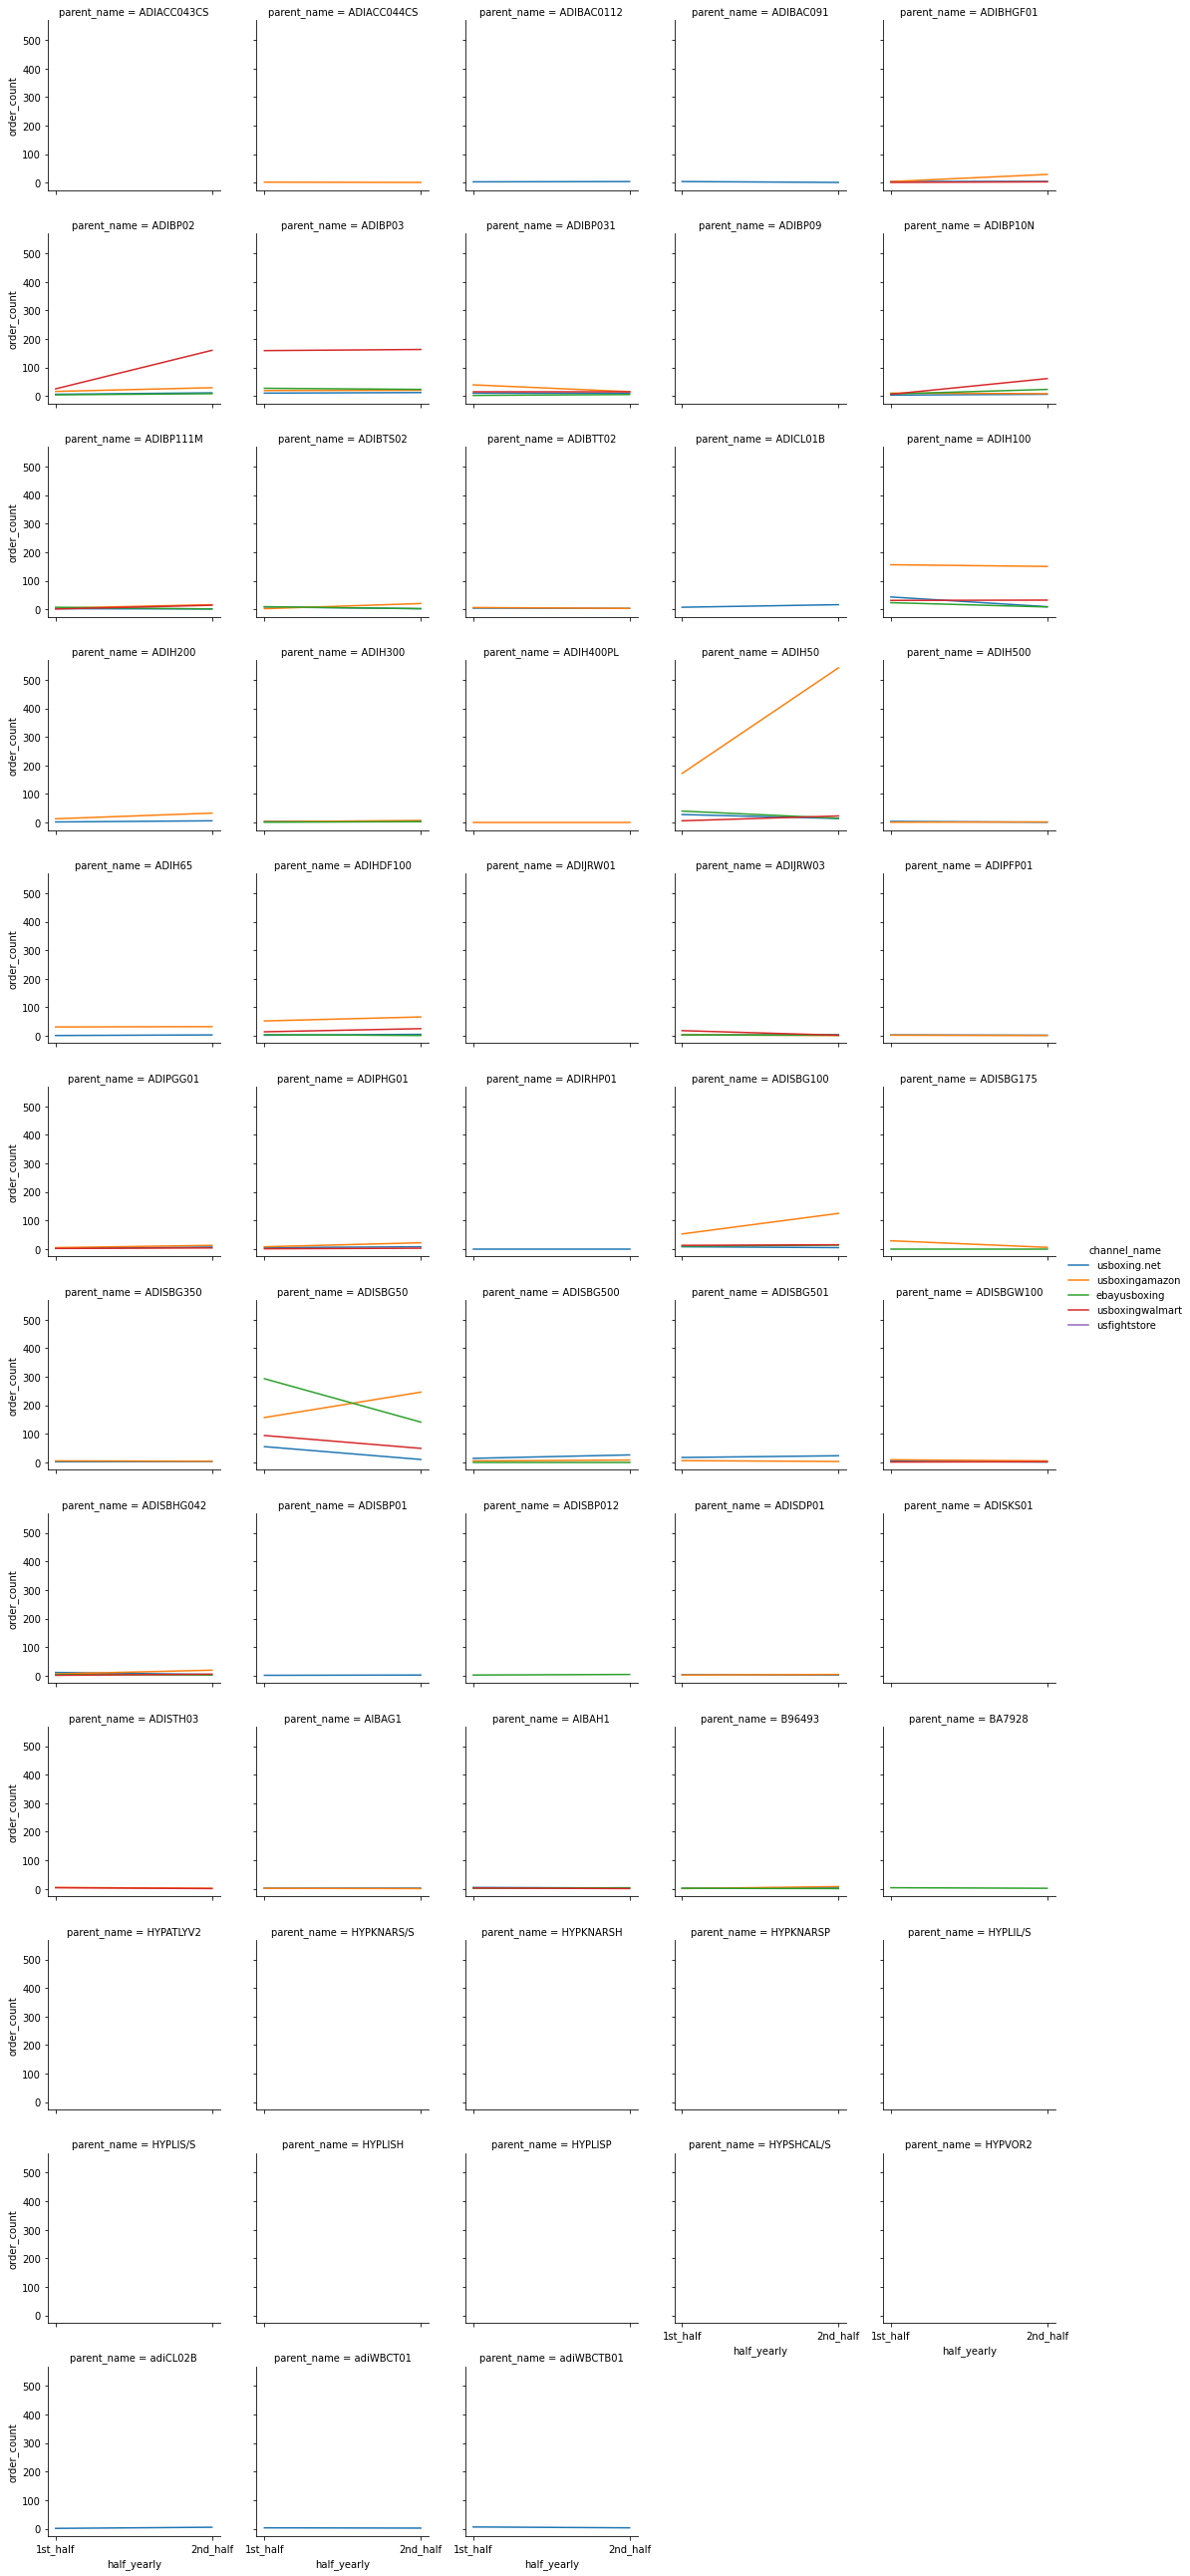

In [13]:
c=sns.FacetGrid(six_months_2020, col='parent_name',hue='channel_name',col_wrap=5)
c=c.map(sns.lineplot,'half_yearly', 'order_count').add_legend()

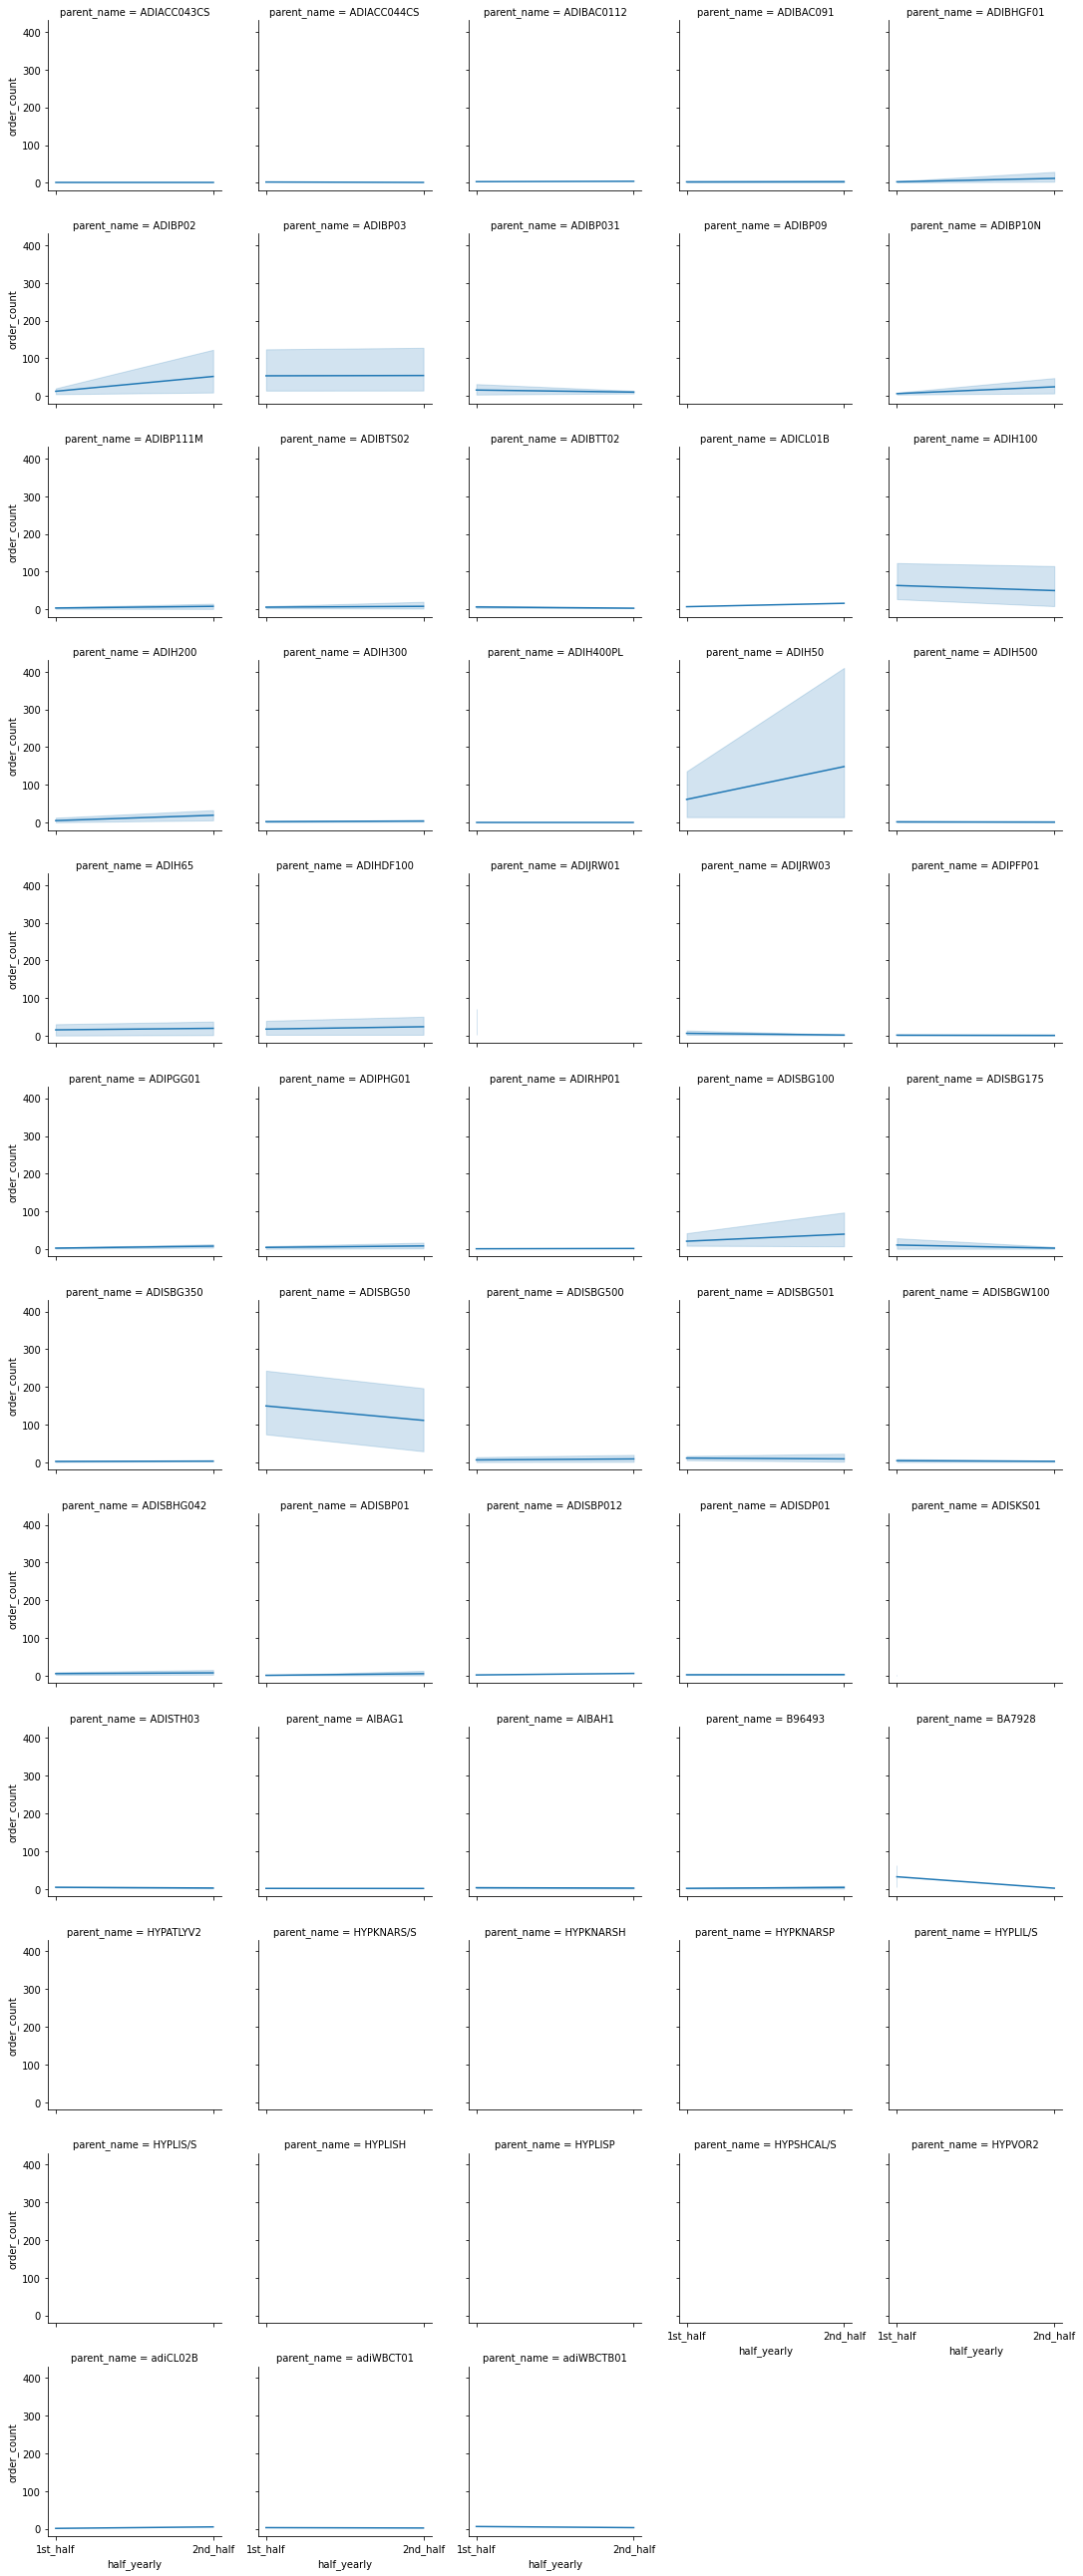

In [14]:
d=sns.FacetGrid(six_months_2020, col='parent_name',col_wrap=5)
d=d.map(sns.lineplot,'half_yearly', 'order_count').add_legend()

In [15]:
orders_2020_by_channel=twenty_twenty.groupby(['parent_name','quarter','channel_name'])['order_id'].count()
orders_2020_by_channel=pd.DataFrame(orders_2020_by_channel)
orders_2020_by_channel
orders_2020_by_channel.columns=['order_count']

In [16]:
orders_2020_by_channel.reset_index(inplace=True)

In [17]:
orders_2020_by_channel.head()

,parent_name,quarter,channel_name,order_count
0,ADIACC043CS,quarter_2,usboxing.net,1
1,ADIACC043CS,quarter_4,usboxingamazon,1
2,ADIACC044CS,quarter_1,usboxingamazon,2
3,ADIACC044CS,quarter_4,ebayusboxing,1
4,ADIACC044CS,quarter_4,usboxing.net,1


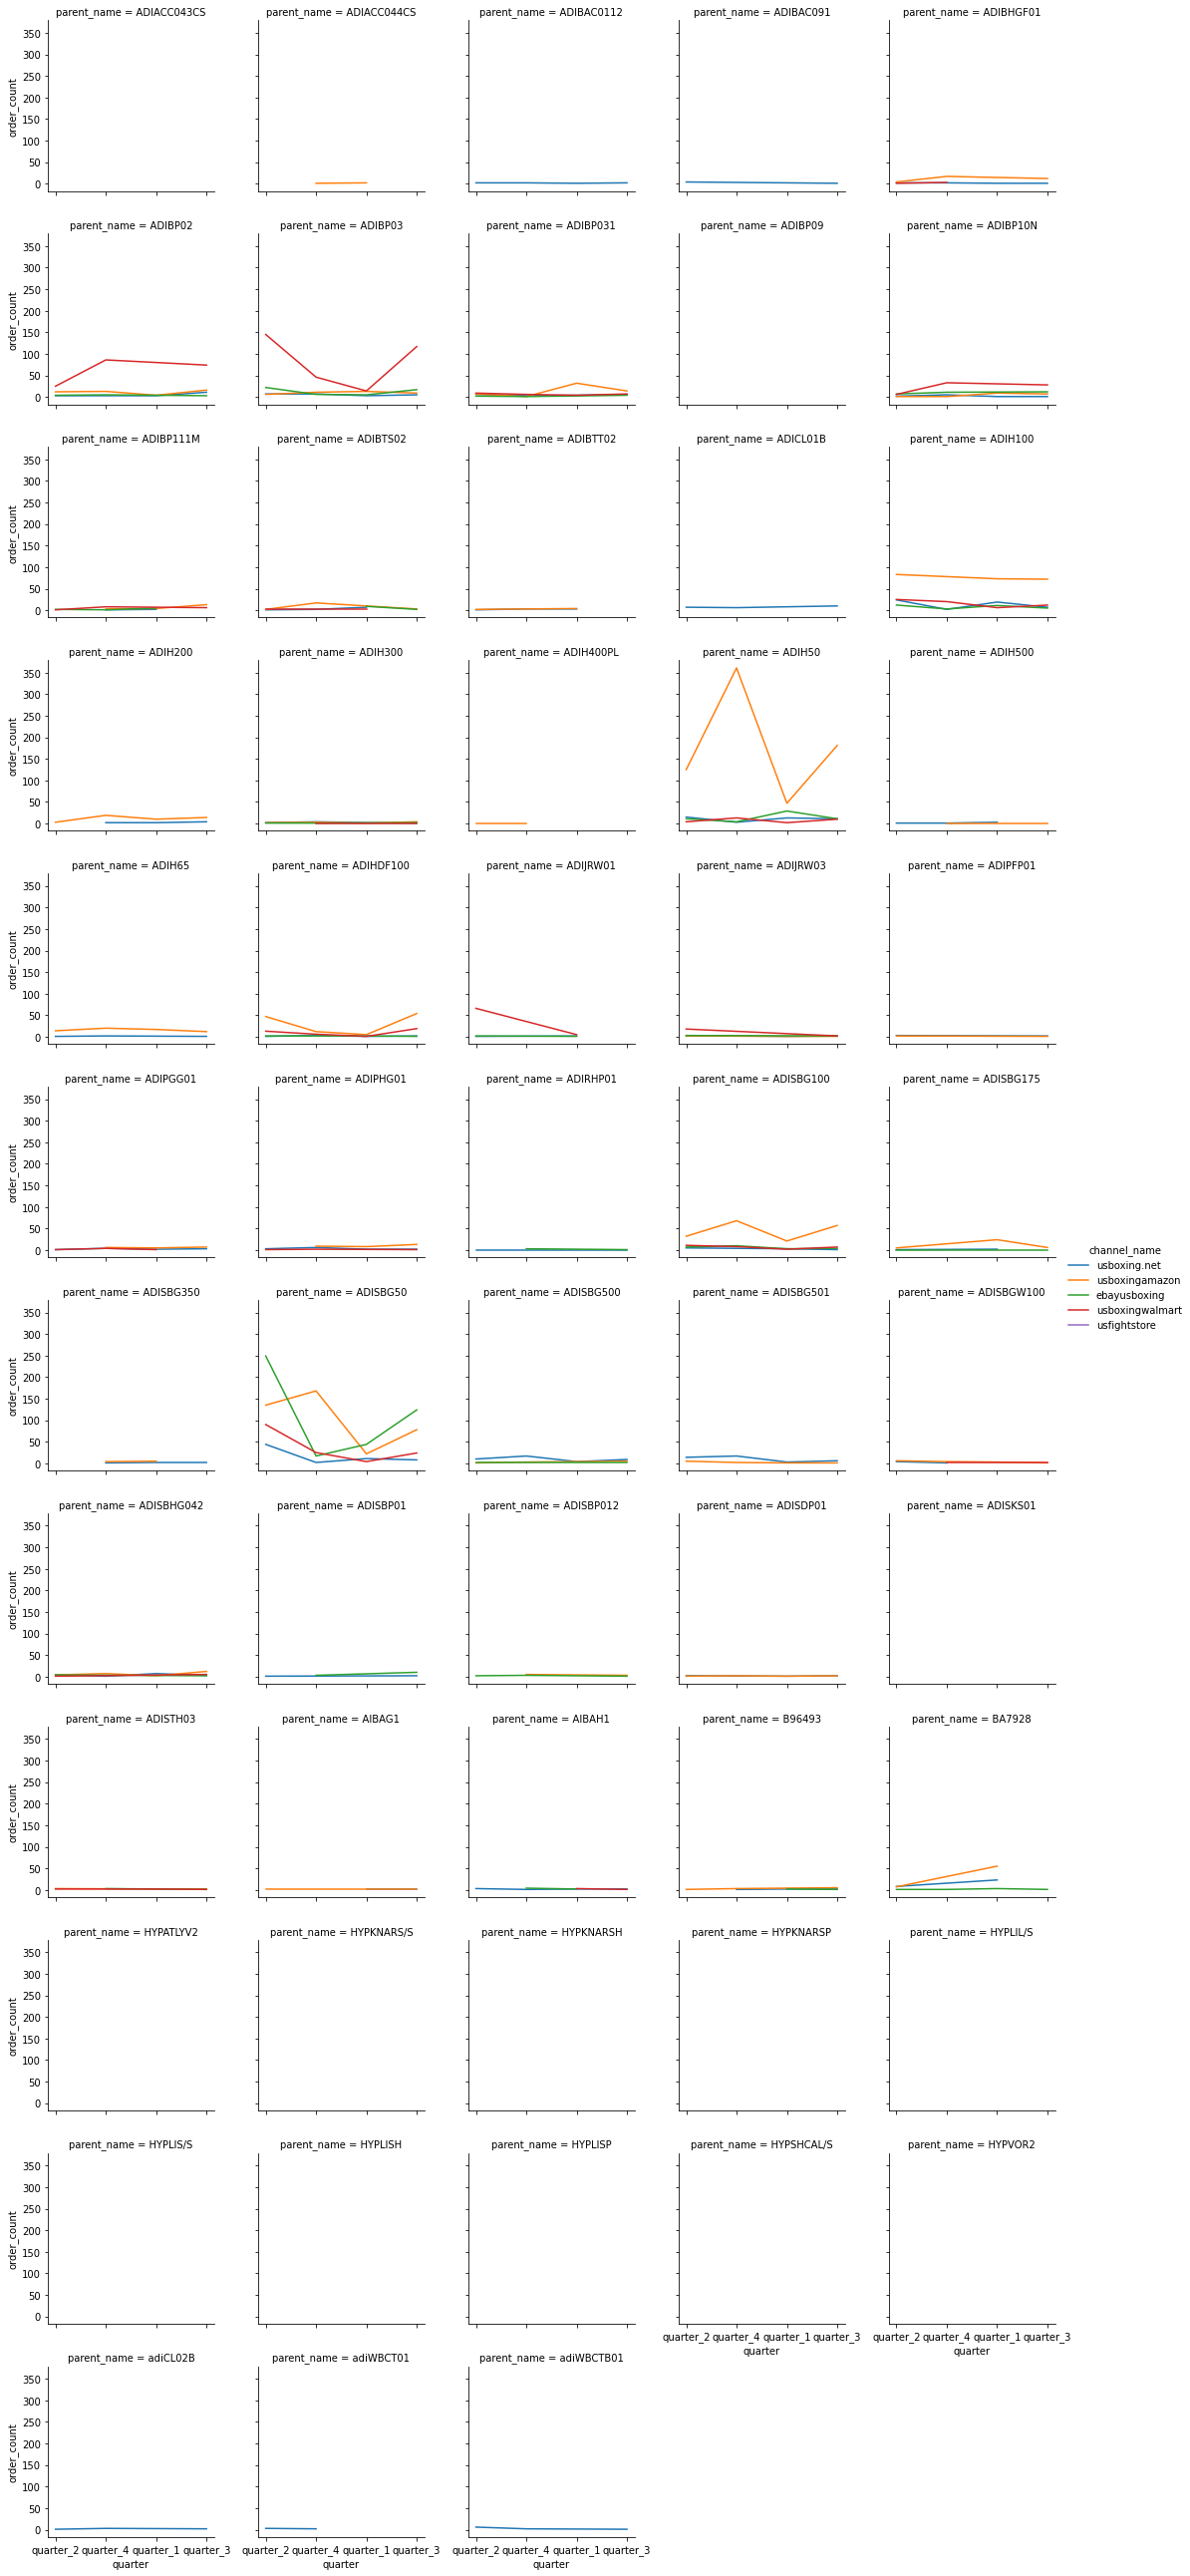

In [18]:
s=sns.FacetGrid(orders_2020_by_channel, col='parent_name',hue='channel_name',col_wrap=5)
s=s.map(sns.lineplot,'quarter', 'order_count').add_legend()

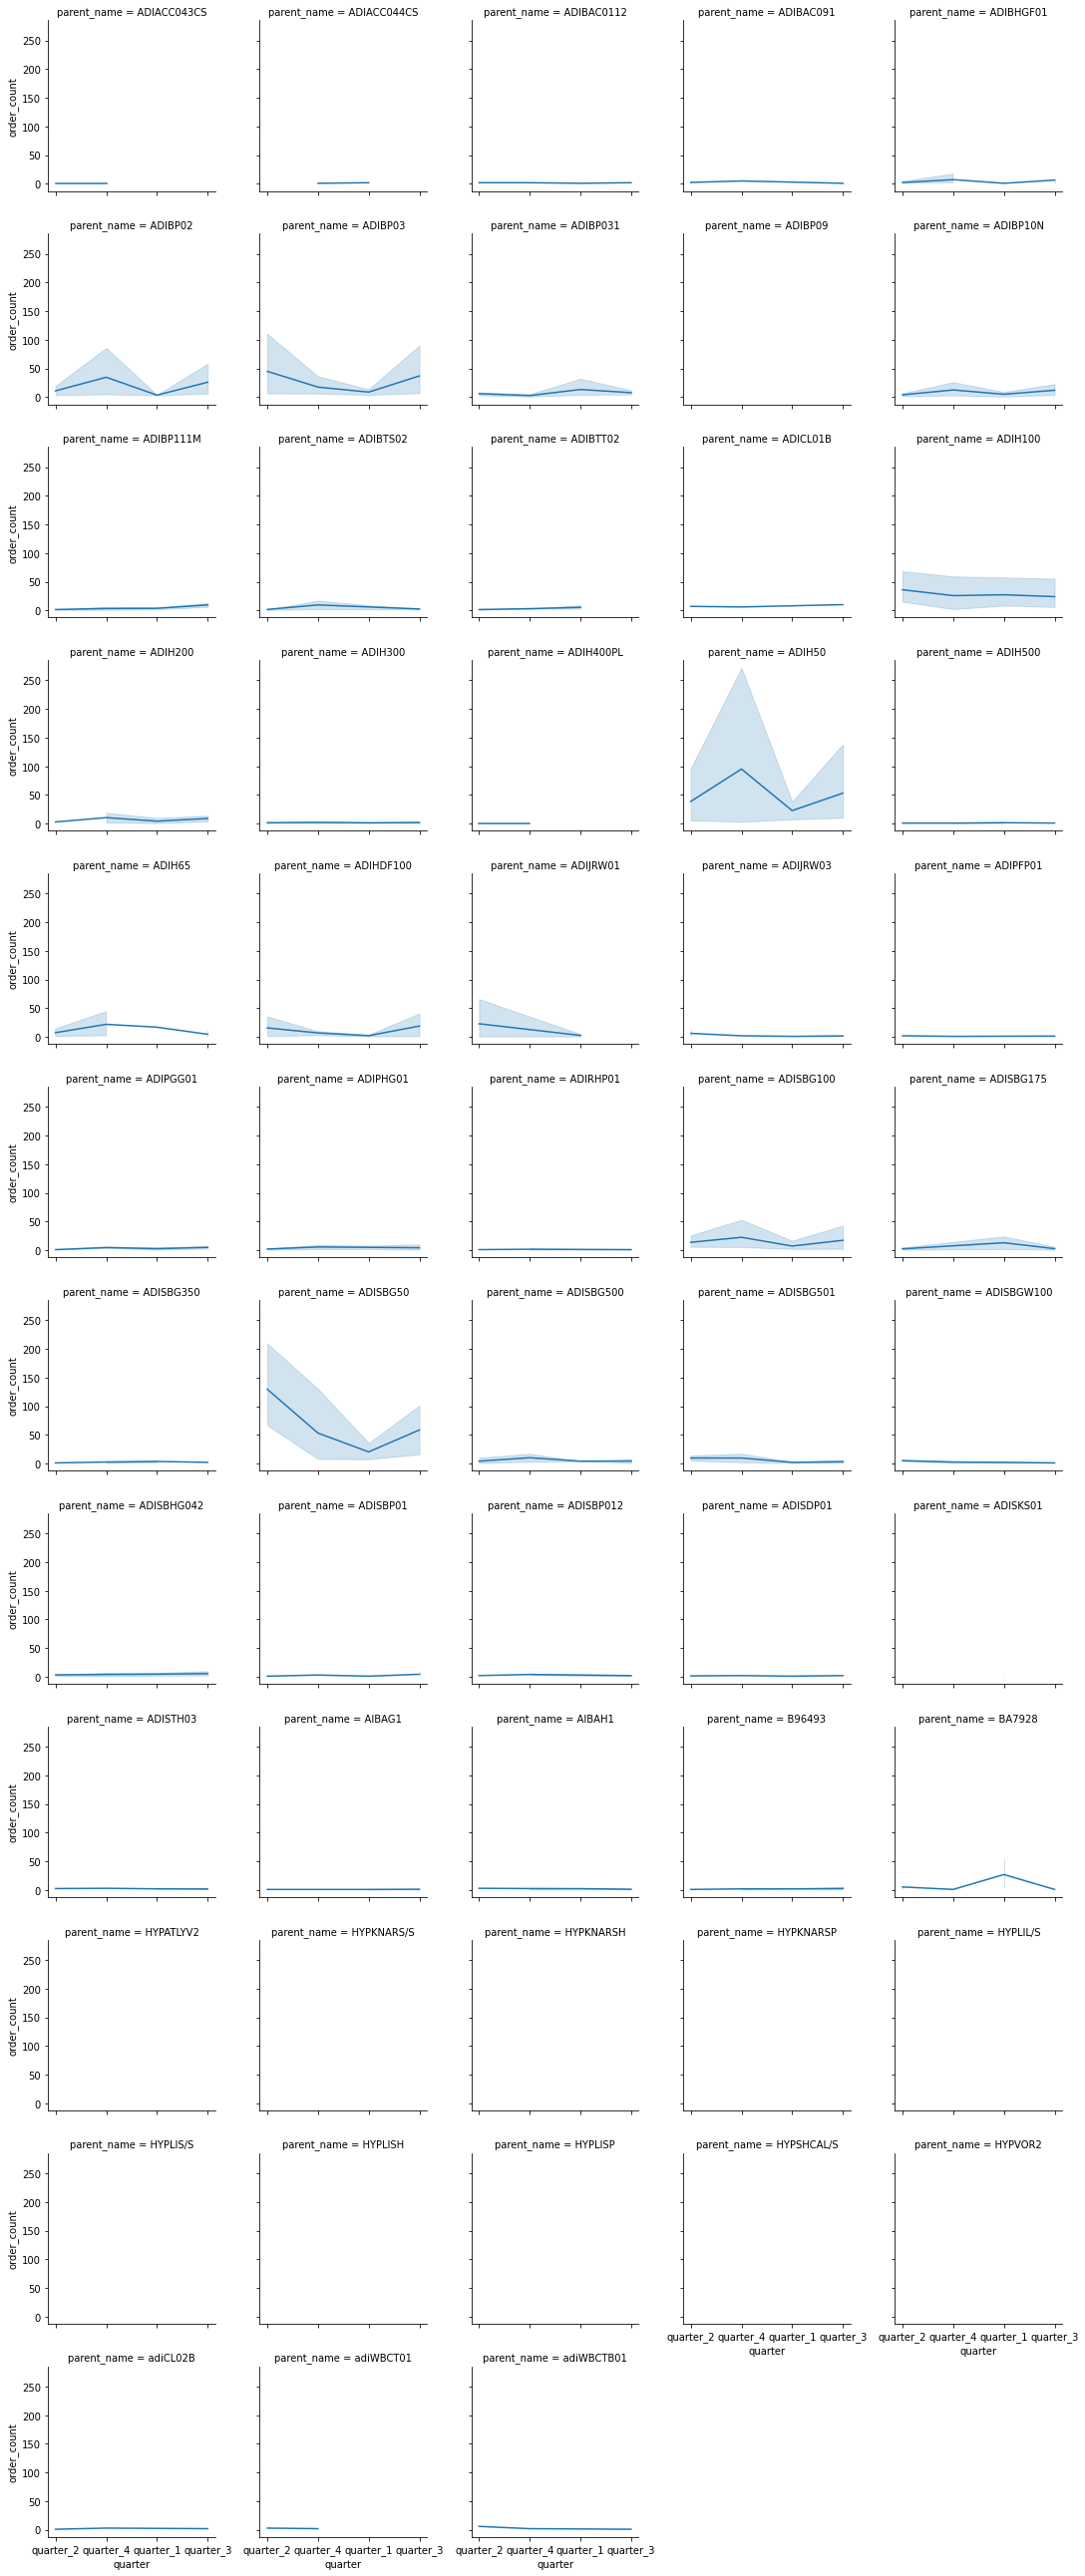

In [19]:
t=sns.FacetGrid(orders_2020_by_channel, col='parent_name',col_wrap=5)
t=t.map(sns.lineplot,'quarter', 'order_count').add_legend()

In [20]:
quarterly_sales_data=twenty_twenty.groupby(['parent_name','quarter','channel_name'])['sub_total'].sum()
quarterly_sales_data=pd.DataFrame(quarterly_sales_data)
quarterly_sales_data
quarterly_sales_data.reset_index(inplace=True)
quarterly_sales_data.head()

,parent_name,quarter,channel_name,sub_total
0,ADIACC043CS,quarter_2,usboxing.net,54.95
1,ADIACC043CS,quarter_4,usboxingamazon,54.95
2,ADIACC044CS,quarter_1,usboxingamazon,109.90
3,ADIACC044CS,quarter_4,ebayusboxing,63.19
4,ADIACC044CS,quarter_4,usboxing.net,54.95


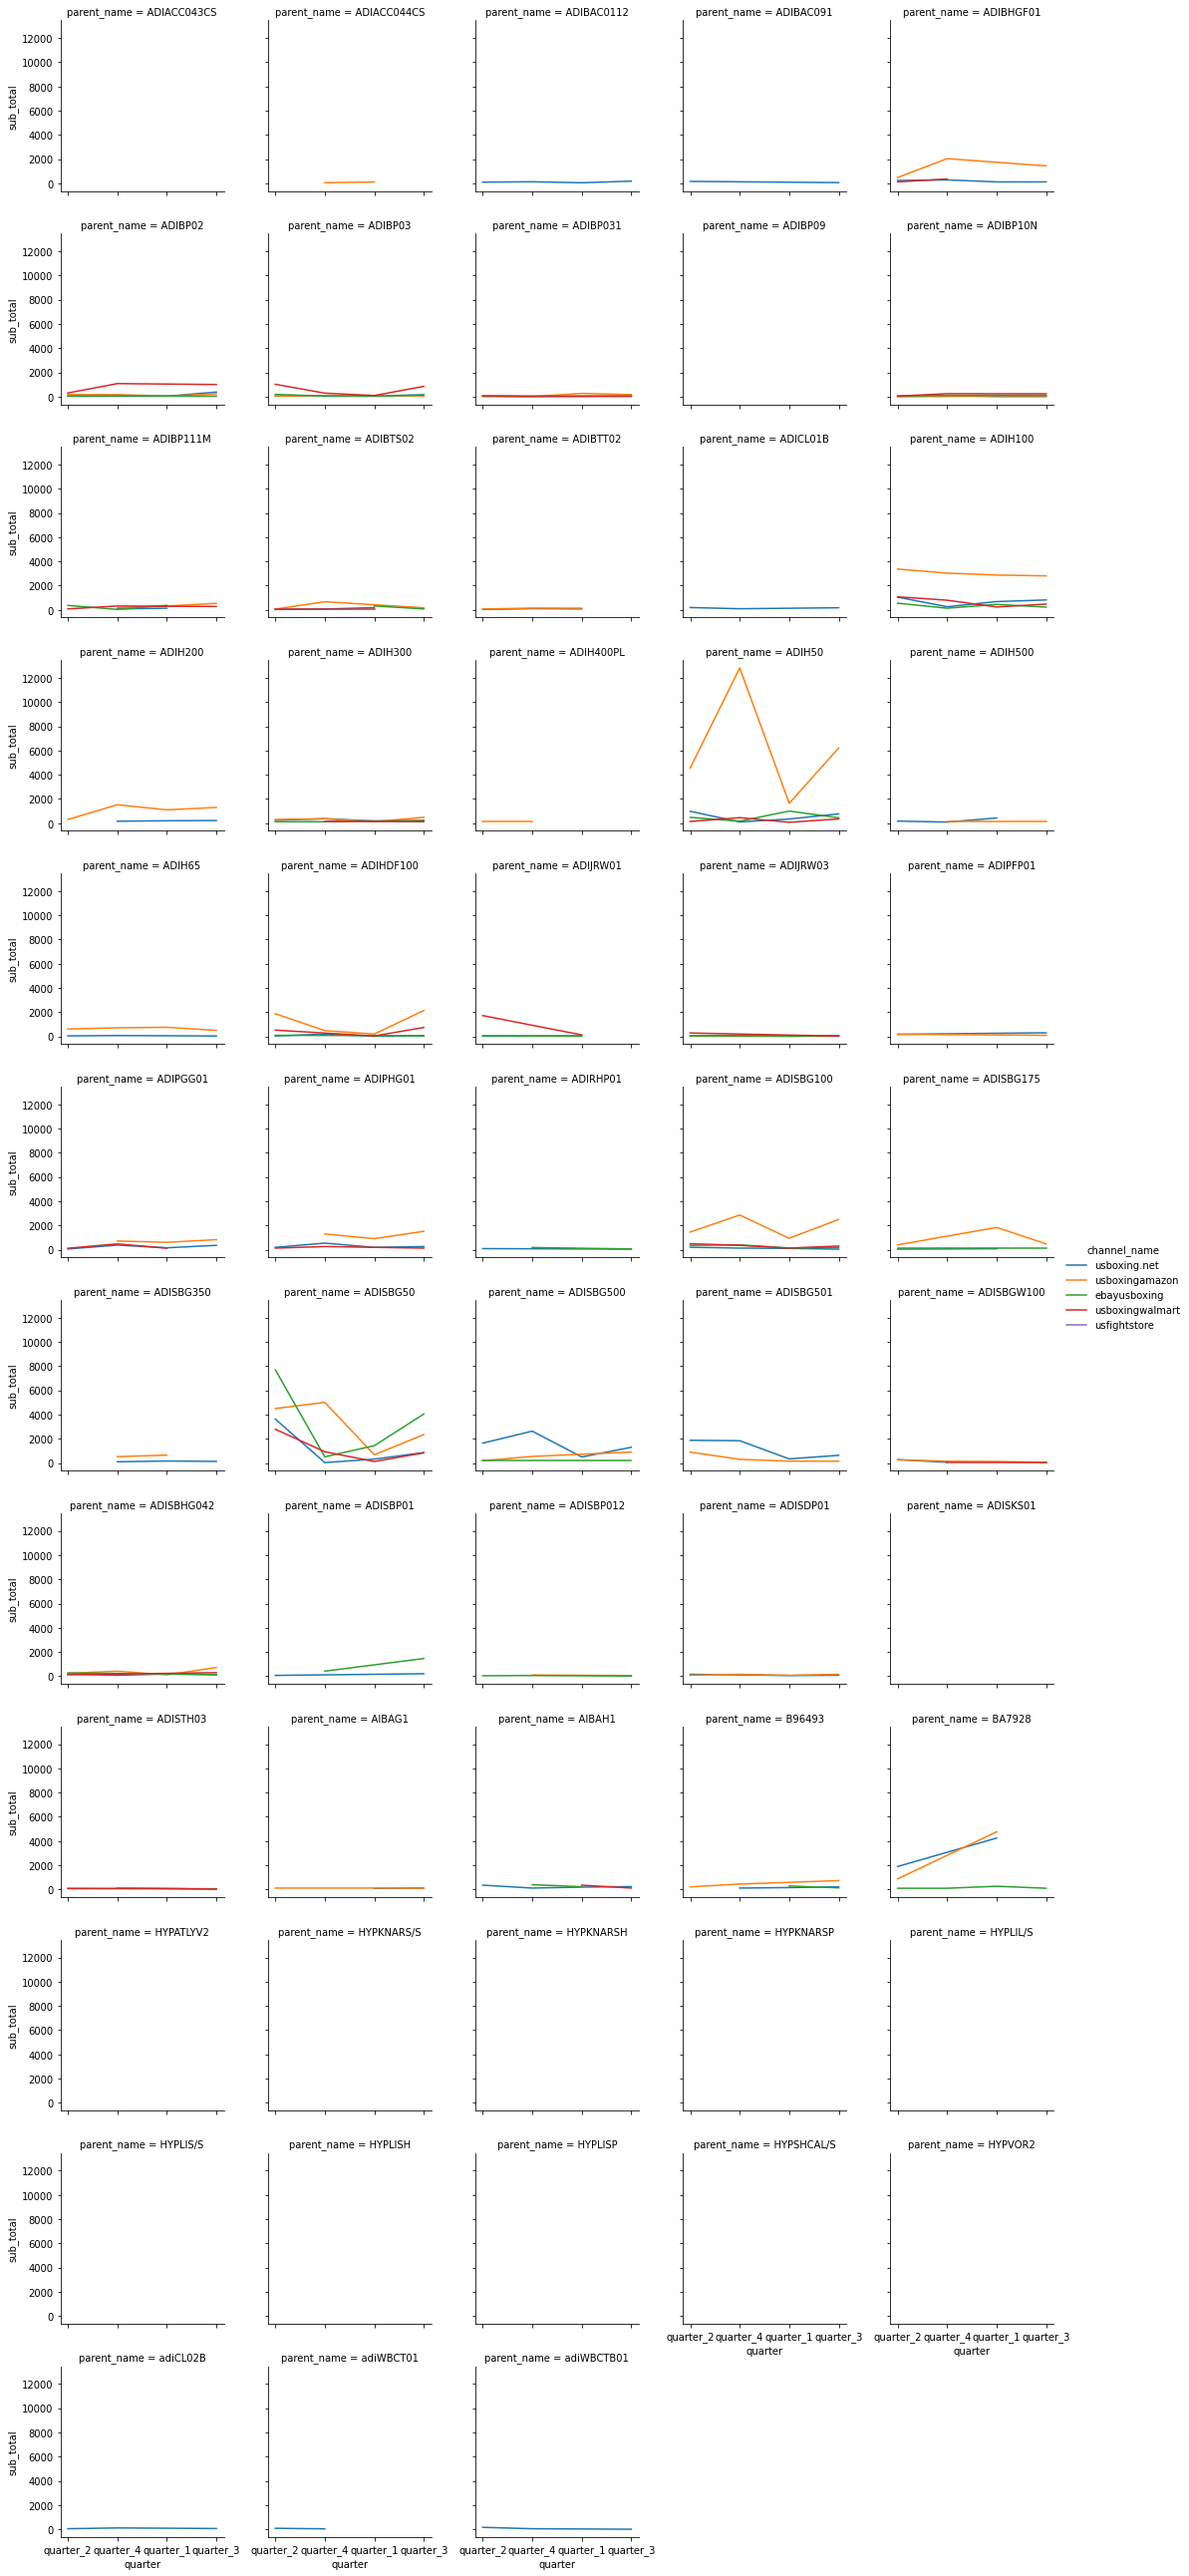

In [21]:
g = sns.FacetGrid(quarterly_sales_data, col='parent_name',hue='channel_name',col_wrap=5)
g = g.map(sns.lineplot,'quarter', 'sub_total' ).add_legend()

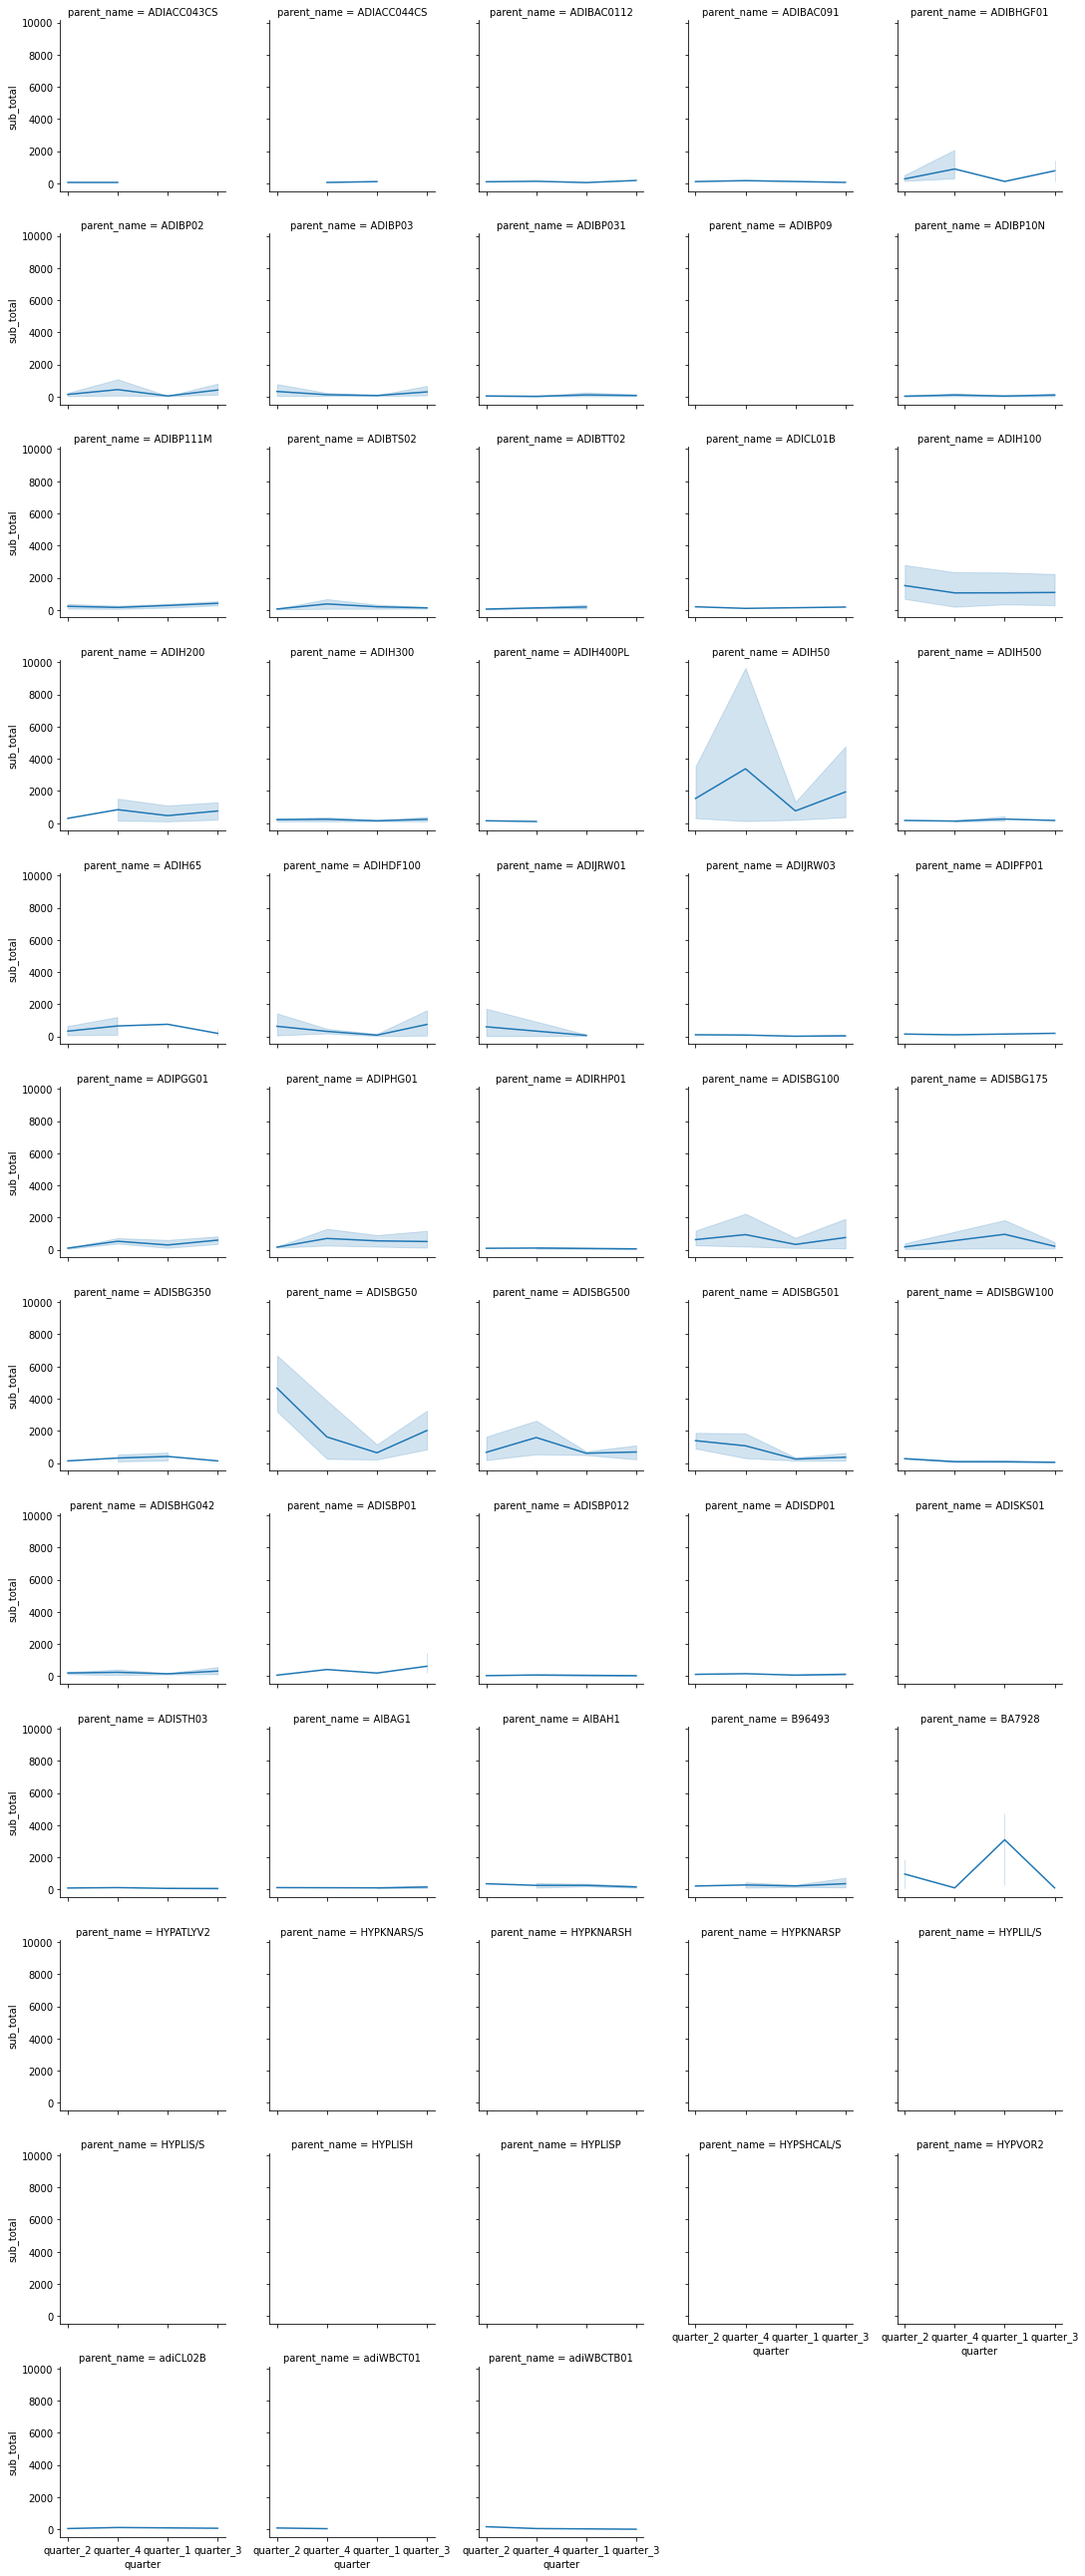

In [22]:
h = sns.FacetGrid(quarterly_sales_data, col='parent_name',col_wrap=5)
h = h.map(sns.lineplot,'quarter', 'sub_total' ).add_legend()

In [23]:
half_yearly_sales=twenty_twenty.groupby(['parent_name','half_yearly','channel_name'])['sub_total'].sum()
half_yearly_sales=pd.DataFrame(half_yearly_sales)
half_yearly_sales.reset_index(inplace=True)
half_yearly_sales.columns=['parent_name','half_yearly','channel_name','sub_total']

In [24]:
half_yearly_sales.head()

,parent_name,half_yearly,channel_name,sub_total
0,ADIACC043CS,1st_half,usboxing.net,54.95
1,ADIACC043CS,2nd_half,usboxingamazon,54.95
2,ADIACC044CS,1st_half,usboxingamazon,109.90
3,ADIACC044CS,2nd_half,ebayusboxing,63.19
4,ADIACC044CS,2nd_half,usboxing.net,54.95


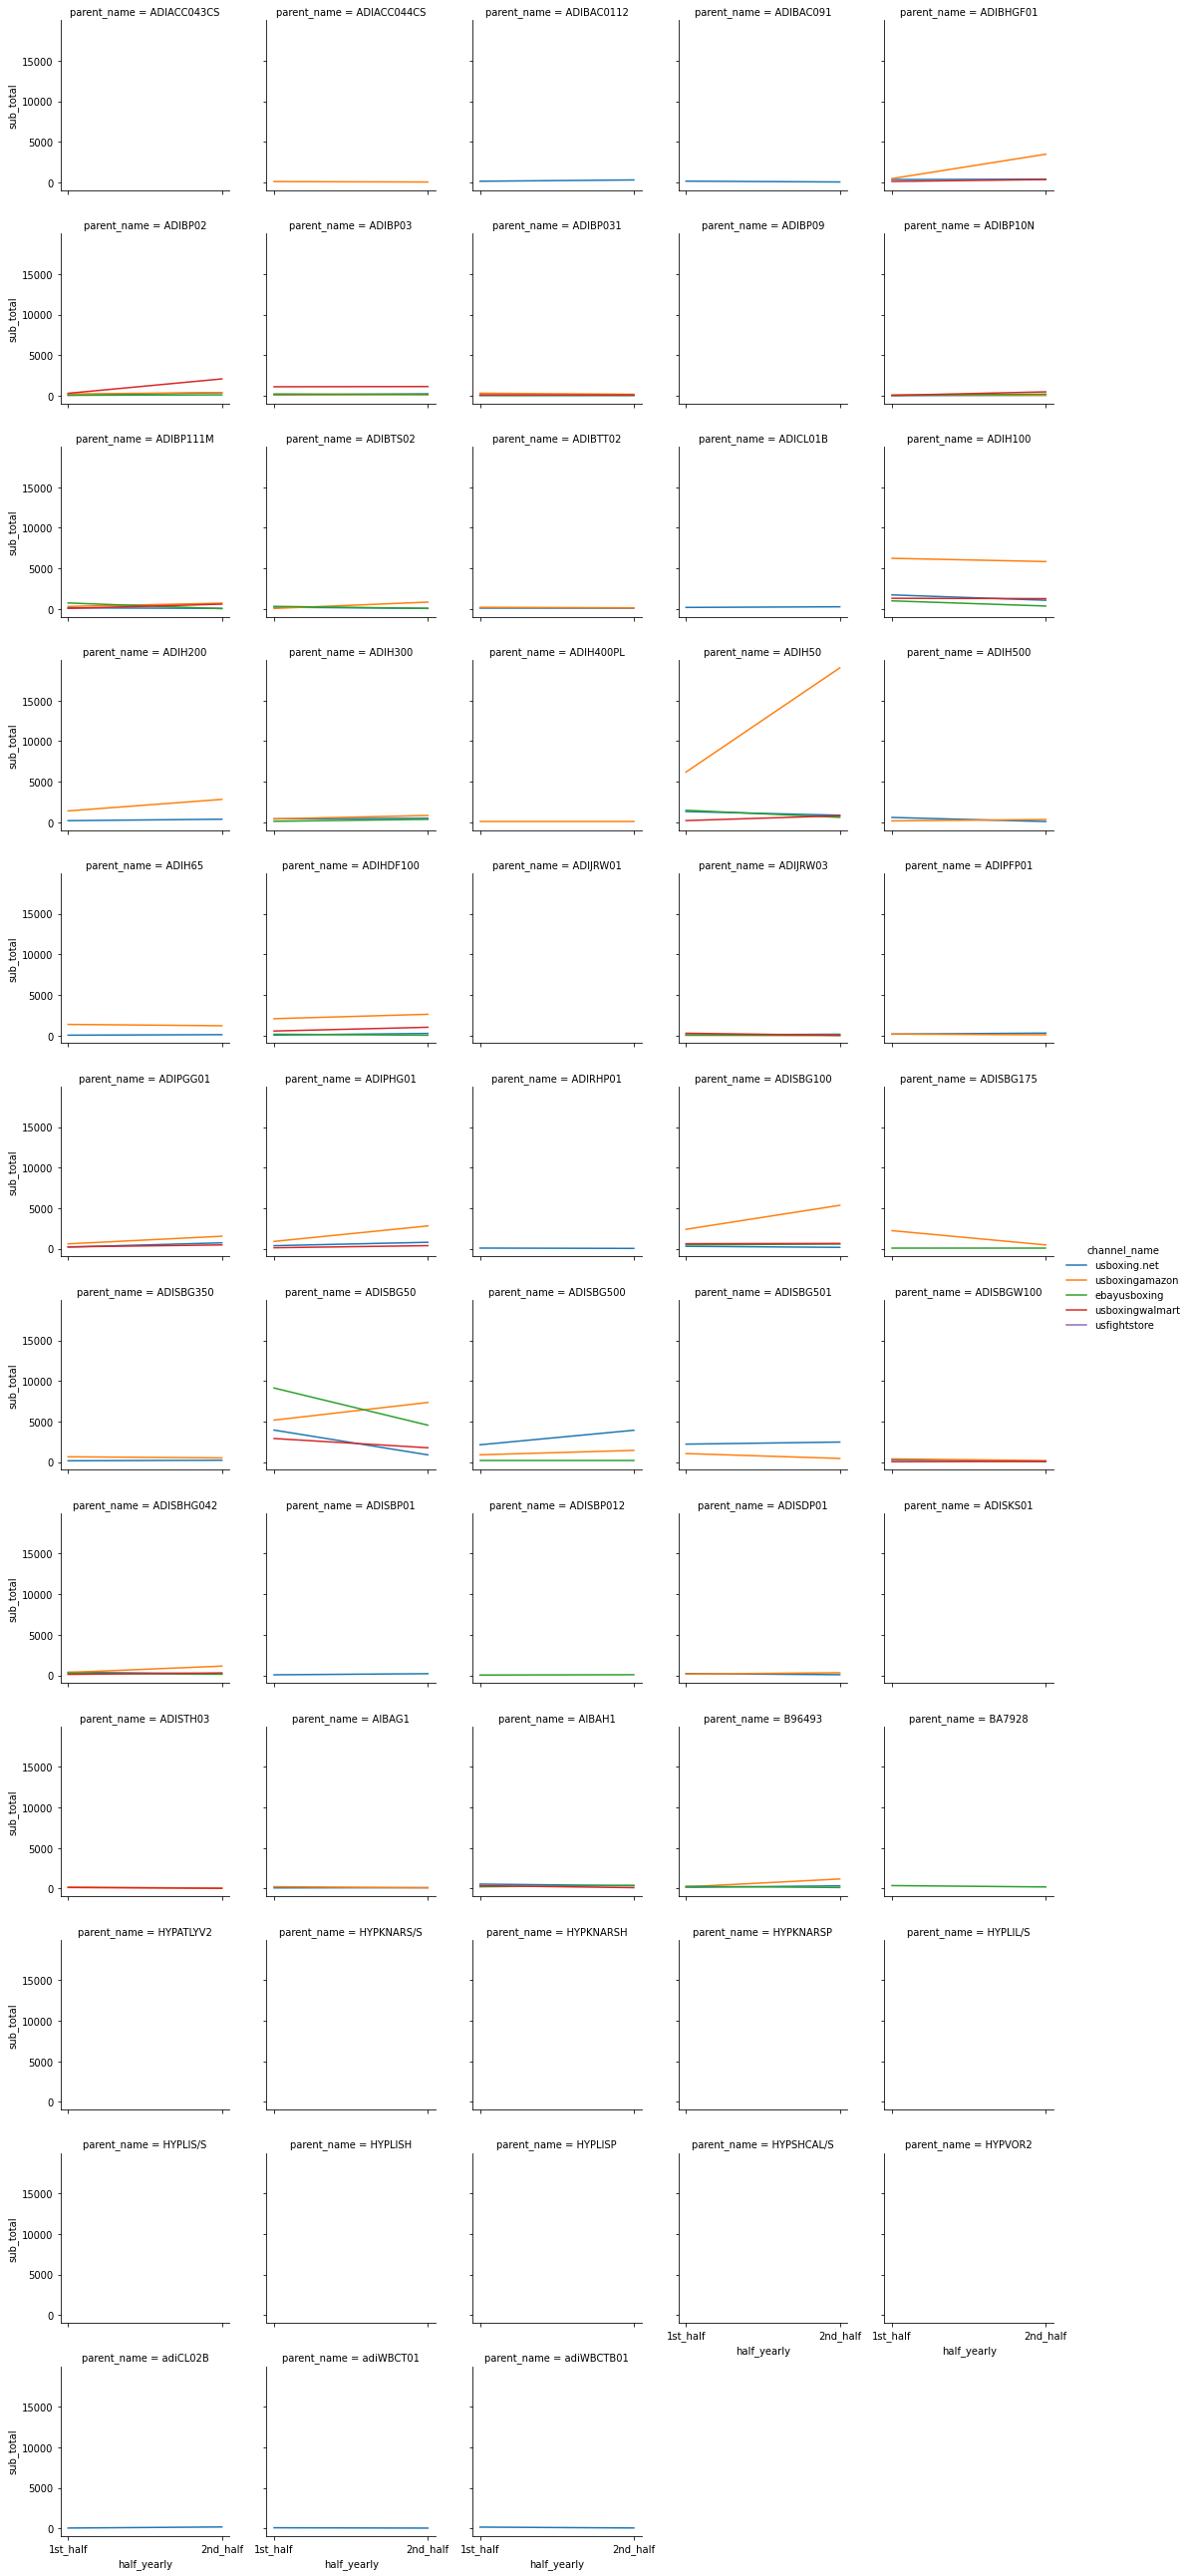

In [25]:
u = sns.FacetGrid(half_yearly_sales, col='parent_name',hue='channel_name',col_wrap=5)
u = u.map(sns.lineplot,'half_yearly', 'sub_total' ).add_legend()

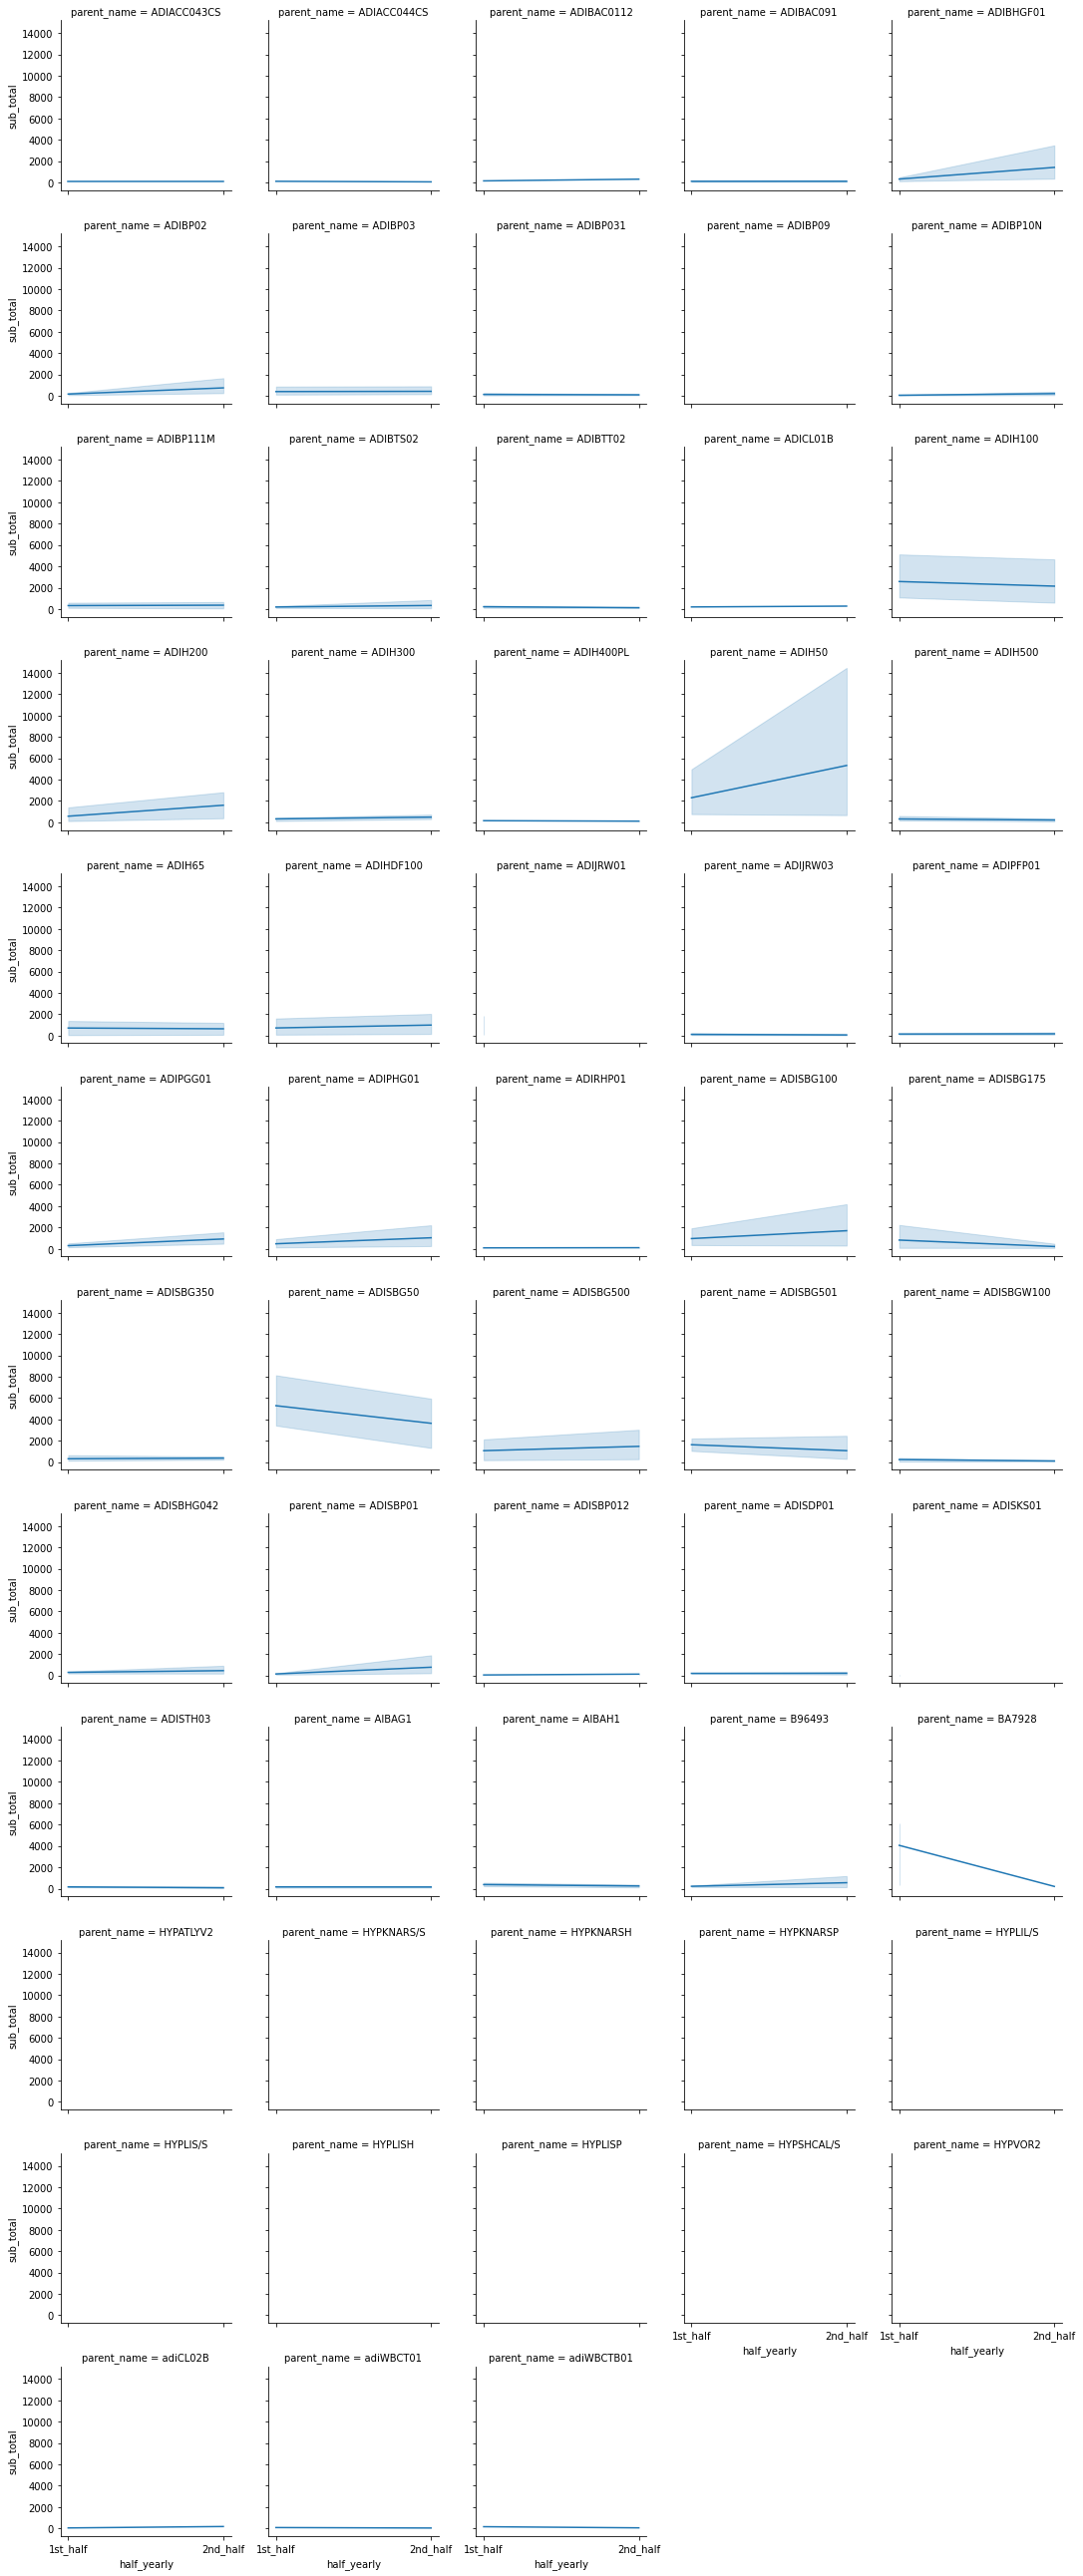

In [26]:
v = sns.FacetGrid(half_yearly_sales, col='parent_name',col_wrap=5)
v = v.map(sns.lineplot,'half_yearly', 'sub_total' ).add_legend()